In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import keras.utils as image
from IPython.utils import io

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import importlib
import pathlib

import requests
from functools import partial

size_ = (10,8)



In [9]:
train_ds = image.image_dataset_from_directory(
    '/home/sarp/DS5460/garbage_classifier/train/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(512,384),
    batch_size=32,
)

Found 2009 files belonging to 6 classes.
Using 1608 files for training.


In [11]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [2]:
class OverfittingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      self.model.stop_training = True
      print('Trying to prevent overfitting - stopping training')

In [3]:
#center crop of incoming image, sizing it down to (224, 224, 3)
def center_crop(img):
    image_array = img
    shape = image_array.shape # H, W, D
    left = int((shape[1]-224)/2)
    right = left + 224
    bottom = int((shape[0]-224)/2)
    top = bottom + 224
    return image_array[bottom:top, left:right]

#random crop of the image within the defined range
def random_crop(img):
    image_array = img
    shape = image_array.shape
    left = np.random.randint(0, shape[1]-224)
    right = left + 224
    bottom = np.random.randint(0, shape[0]-224)
    top = bottom + 224
    return image_array[bottom:top, left:right]

#with some randomness, either center crop or random crop the image, as well as either flip or do not flip the image.
def process_img(img, crop=True):
    if crop:
        if np.random.rand() > 0.5:
            cropped = center_crop(img)
            if np.random.rand() > 0.5:
                return np.flip(cropped, axis=np.random.randint(0, 2))
            else:
                return cropped
        else:
            cropped = random_crop(img)
            if np.random.rand() > 0.5:
                return np.flip(cropped, axis=np.random.randint(0, 2))
            else:
                return cropped
    else:
        return img
    


    


In [6]:
# Just placing everything in a class to make analysis easier
class TrashClassifer():
    
    def __init__(self, home_path='/home/sarp/DS5460', main_dir='garbage_classifier', model_name='vgg16', crop=False):
        # Define some constants
        self.HOME = Path(home_path)
        self.MAIN_DIR = self.HOME / main_dir #the main directory of this project to include all the data
        
        # Data augmentation switch
        self.crop = crop
        


        self.TEST_PATH = self.MAIN_DIR / 'test'
        self.TRAIN_PATH = self.MAIN_DIR / 'train'

        #TensorBoard - log model statistics
        self.LOGDIR = self.MAIN_DIR / 'my_logs'
        
        self.MODEL_DIR = self.MAIN_DIR / 'models'
        
        self.BASE_URL = 'https://raw.githubusercontent.com/hoganj15/Waste_Image_Classifier/main/images_multiclass'
        
        self.set_up()
        
        # some tricks to load models by name
        from inspect import getmembers, isfunction
        self.available_models = {o[0].lower():o[1]for o in getmembers(keras.applications) if isfunction(o[1])}
        
        model_module = importlib.import_module('keras.applications' + '.' + model_name)
        self.preprocess(model_module.preprocess_input)
        return
        self.model_path = self.MODEL_DIR / model_name
        if self.model_path.exists():
            print('Model exists, not training.')
            self.model = tf.keras.models.load_model(self.model_path)
        
        else:
            model_instantiator = self.available_models[model_name]
            self.train(model_instantiator, weights="imagenet", include_top=False, input_shape=(224, 224, 3))
        
        self.test_model()
    
    def get_run_logdir(self):
        run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
        return self.LOGDIR / run_id

    
    def set_up(self):
        if not self.TEST_PATH.exists():
            self.TEST_PATH.mkdir(parents=True)
        if not self.TRAIN_PATH.exists():
              self.TRAIN_PATH.mkdir(parents=True)
        #reading in the files required for image imports

        test_csv_path = self.TEST_PATH / 'test_files.csv'       
        if not test_csv_path.exists():
            r = requests.get(self.BASE_URL + '/' + test_csv_path.name)
            test_csv_path.write_text(r.text)
        
        
        train_csv_path = self.TRAIN_PATH / pathlib.Path('train_files.csv')
        if not train_csv_path.exists():
            r = requests.get(self.BASE_URL + '/' + train_csv_path.name)
            train_csv_path.write_text(r.text)

        file_names = pd.read_csv(test_csv_path)
        for label in file_names.label.unique().tolist():
            label_path = self.TEST_PATH / label
            if not label_path.exists():
                label_path.mkdir() #create a folder for each class in the test directory
            files_to_read = file_names[file_names['label'] == label] #filter the files to read for that folder
            if len(list(label_path.iterdir())) < len(files_to_read): 
                for file_name in files_to_read['file_name'].tolist():
                    url = self.BASE_URL + '/' + 'test' + '/' + label + '/' + file_name
                    r = requests.get(url)
                    file_path = label_path / file_name
                    file_path.write_bytes(r.content)
   
        file_names = pd.read_csv(train_csv_path)
        for label in file_names.label.unique().tolist():
            label_path = self.TRAIN_PATH / label
            if not label_path.exists():
                label_path.mkdir() #create a folder for each class in the train directory
            files_to_read = file_names[file_names['label'] == label] #filter the files to read for that folder
            if len(list(label_path.iterdir())) < len(files_to_read): #only read in images if they aren't already there
                for file_name in files_to_read['file_name'].tolist():
                    url = self.BASE_URL + '/' + 'train' + '/' + label + '/' + file_name
                    r = requests.get(url)
                    file_path = label_path / file_name
                    file_path.write_bytes(r.content)
                    


    

    def preprocess(self, preprocess_function):
        print(preprocess_function)
        original_size = (512, 384)
        target_size = (224, 224)
        batch_size = 32
        process = partial(process_img, crop=self.crop)
        
        # resize, rescale, random crop and random flip
        # Set preprocessing based on the crop switch above
        
        if self.crop:
            preprocessing = tf.keras.Sequential([
                keras.layers.RandomFlip("horizontal_and_vertical"),
                keras.layers.RandomCrop(*target_size),
                keras.layers.Resizing(*target_size),
                keras.layers.Rescaling(1./255),
            ])
        
        else:
            preprocessing = tf.keras.Sequential([
                keras.layers.Resizing(*target_size),
                keras.layers.Rescaling(1./255),
            ])
        
        folder_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        
        train_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/train/',
            validation_split=0.2,
            subset='training',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,
        )

        val_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/train/',
            validation_split=0.2,
            subset='validation',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,            
        )

        test_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/test/',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,
        )
        
        self.train_ds = train_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        self.val_ds = test_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        self.test_ds = test_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        
        for im, _ in train_ds.take(1):
            plt.figure(figsize=(10, 10))
            first_image = im[0]
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                #augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
                plt.imshow(first_image / 255)
                plt.axis('off')


        
    def train(self, transfer_model, **kwargs):
        base_model = transfer_model(**kwargs)
        
        run_logdir = self.get_run_logdir()
        tensorboard_callback = keras.callbacks.TensorBoard(run_logdir, update_freq="epoch")

        #freeze the base model 
        base_model.trainable = False

        #define the type of NN architecture - sequential model specifies a linear stack of layers 
        model = keras.models.Sequential()

        #add the pre-trained model
        model.add(base_model)

        #pool layer to prepare data as input into dense layer 
        model.add(keras.layers.GlobalAveragePooling2D())
        model.add(keras.layers.Dense(256, activation='relu'))
        #batch normalization layer re-centers and re-scales the network - helps accelerate training
        model.add(keras.layers.BatchNormalization())
        #dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
        model.add(keras.layers.Dropout(0.2))
        #flatten layer to single array for input into dense layer 
        model.add(keras.layers.Flatten())
        # prediction layer - 6 neurons = 6 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
        model.add(keras.layers.Dense(6, activation='softmax'))
        #compile model, specify sparse categorical crossentropy for classification and evaluate accuracy
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #train model for 40 epochs 
        history = model.fit(self.train_ds, epochs=40, validation_data = self.val_ds, callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), OverfittingCallback(), tensorboard_callback])
        #unfreeze base model 
        base_model.trainable = True
        model.summary()
        history = model.fit(self.train_ds, epochs=40, validation_data=self.val_ds, callbacks=[keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'), OverfittingCallback()])
        model.save(self.model_path)
        self.model = model
        
    def class_convert(self, classess):
        pred=[]
        for i in classess:
            if i ==0:
                pred.append('Cardboard')
            elif i==1:
                pred.append('Glass')
            elif i==2:
                pred.append('Metal')
            elif i==3:
                pred.append('Paper')
            elif i==4:
                pred.append('Plastic')
            elif i==5:
                pred.append('Trash')
        return pred

    def test_model(self):
        
        loss, accuracy = self.model.evaluate(self.test_ds)
        
        
#         self.model.summary()
#         incorrect = dict()
#         for idx, predictions in enumerate(self.model.predict(self.test_ds)):
#             if np.argmax(predictions) != self.test_ds.[idx][0]:
#                 incorrect[idx] = {'Predicted': np.argmax(predictions), 'Actual': y_test[idx][0]}

#         incorrect_preds = pd.DataFrame.from_dict(incorrect, orient='index')
#         incorrect_preds.reset_index()
#         #generate predictions using the test dataset
#         predicted_class=np.argmax(self.model.predict(self.test_ds), axis = -1)
#         predicted_class
#         corr=0
#         false=0
#         for i in range(len(y_test)):
#             if y_test[i]==predicted_class[i]:
#                  corr=corr+1
#             else:
#                 false=false+1

#         print("Correct:",corr)
#         print("False",false)
#         print("accuracy:", corr / (false+corr))

#         pred_class=self.class_convert(predicted_class)
#         y_class=self.class_convert(y_test)

#         cm=confusion_matrix(y_class,pred_class)
#         df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
#         df_cm.columns = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']
#         df_cm.index = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']

#         fig = plt.subplots(figsize=size_)
#         sb.set(font_scale=1)
#         sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis") # font size
#         plt.show()



weights="imagenet", include_top=False, input_shape=(224, 224, 3)

<function preprocess_input at 0x7f84688f3d30>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.


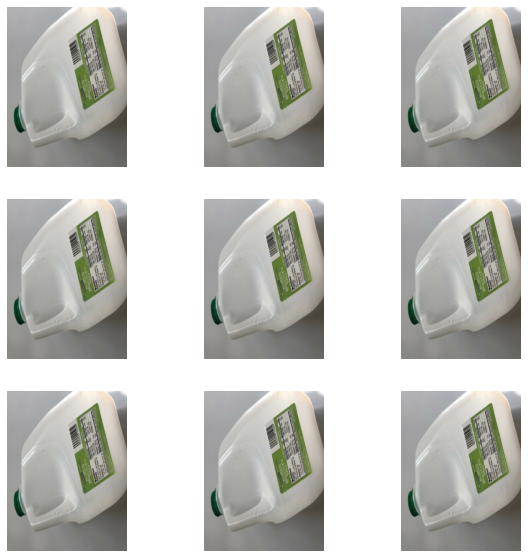

In [7]:
classifier = TrashClassifer(model_name='mobilenet', crop=False)

In [3]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2022-12-13 15:26:07.896797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 15:26:08.359525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 15:26:08.359548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 15:26:08.402813: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regi

## Step 6: Generate Predictions & View Model Results

####6.1: View Incorrect Predictions
First, let's look at the predictions that were classified incorrectly. 


In [26]:
def class_convert(classess):
    pred=[]
    for i in classess:
        if i ==0:
            pred.append('Cardboard')
        elif i==1:
            pred.append('Glass')
        elif i==2:
            pred.append('Metal')
        elif i==3:
            pred.append('Paper')
        elif i==4:
            pred.append('Plastic')
        elif i==5:
            pred.append('Trash')
    return pred

In [27]:
def test_model(model_path):
    model = tf.keras.models.load_model(model_path)
    incorrect = dict()
    for idx, predictions in enumerate(model.predict(X_test)):
      if np.argmax(predictions) != y_test[idx][0]:
        incorrect[idx] = {'Predicted': np.argmax(predictions), 'Actual': y_test[idx][0]}

    incorrect_preds = pd.DataFrame.from_dict(incorrect, orient='index')
    incorrect_preds.reset_index()
    #generate predictions using the test dataset
    predicted_class=np.argmax(model.predict(X_test), axis = -1)
    predicted_class
    corr=0
    false=0
    for i in range(len(y_test)):
        if y_test[i]==predicted_class[i]:
             corr=corr+1
        else:
            false=false+1

    print("Correct:",corr)
    print("False",false)
    print("accuracy:", corr / (false+corr))

    pred_class=class_convert(predicted_class)
    y_class=class_convert(y_test)

    cm=confusion_matrix(y_class,pred_class)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
    df_cm.columns = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']
    df_cm.index = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']

    fig = plt.subplots(figsize=size_)
    sb.set(font_scale=1)
    sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis") # font size
    plt.show()


####6.2: Visualize Predictions 
Since the CNN classifier is only capable of generating numerical predictions from 0-5, we can now generate predictions and then assign them back to their associated garbage class. After doing so, we can plot each image, its true label, and compare this to the predicted label.

In [7]:
#plot the image from the test dataset, the predicted garbage label, and the actual garbage label

L=7
W=7
fig,axes=plt.subplots(L,W,figsize=(17,17))
axes=axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    if pred_class[i] == y_class[i]:
      axes[i].set_title('Prediction={}\n True={}'.format(pred_class[i],y_class[i]), color='C2')
    else: 
      axes[i].set_title('Prediction={}\n True={}'.format(pred_class[i],y_class[i]), color='C3')
    axes[i].axis('off')

plt.subplots_adjust(wspace=2,hspace=2)

NameError: name 'plt' is not defined